# Week 4: Evaluation Homework

In this homework, we will use Credit Card Data from book "Econometric Analysis".

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [1]:
import pandas as pd

df = pd.read_csv("AER_credit_card_data.csv")
df.head().T

,0,1,2,3,4
card,yes,yes,yes,yes,yes
reports,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667
income,4.52,2.42,4.5,2.54,9.7867
share,0.03327,0.005217,0.004156,0.065214,0.067051
expenditure,124.9833,9.854167,15.0,137.8692,546.5033
owner,yes,no,yes,no,yes
selfemp,no,no,no,no,no
dependents,3,3,4,0,2
months,54,34,58,25,64


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [2]:
df["card"] = (df["card"] == "yes").astype(int)

In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train["card"]
y_val = df_val["card"]
y_test = df_test["card"]

del df_train["card"]
del df_val["card"]
del df_test["card"]

len(df_train), len(df_val), len(df_test)

(791, 264, 264)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [4]:
from sklearn.metrics import roc_auc_score

scores = {}
for col in ["reports", "dependents", "active", "share"]:
    score = roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col])
    scores[col] = round(score,4)

pd.Series(scores).sort_values(ascending=False)

share         0.9892
reports       0.7167
active        0.6043
dependents    0.5328
dtype: float64

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [5]:
from sklearn.feature_extraction import DictVectorizer

features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

X_train_dicts = df_train[features].to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dicts)

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [7]:
X_val_dicts = df_val[features].to_dict(orient="records")
X_val = dv.transform(X_val_dicts)
y_prob = model.predict_proba(X_val)[:,1]

auc_score = roc_auc_score(y_val, y_prob)
print(f"{auc_score=:.3f}")

auc_score=0.995


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?


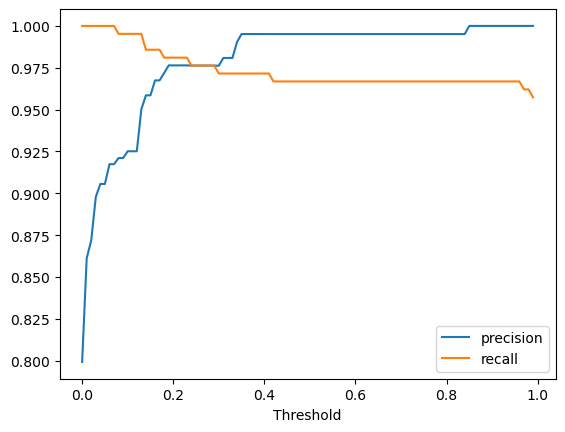

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score

scores = []
for thresh in np.arange(0, 1, 0.01):
    y_pred = y_prob > thresh
    p = precision_score(y_val, y_pred)
    r = recall_score(y_val, y_pred)
    scores.append((thresh, p, r))

columns = ["threshold", "precision", "recall"]
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores["threshold"], df_scores["precision"], label="precision")
plt.plot(df_scores["threshold"], df_scores["recall"], label="recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [9]:
df_scores[df_scores["precision"] == df_scores["recall"]]

,threshold,precision,recall
24,0.24,0.976303,0.976303
25,0.25,0.976303,0.976303
26,0.26,0.976303,0.976303
27,0.27,0.976303,0.976303
28,0.28,0.976303,0.976303
29,0.29,0.976303,0.976303


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

In [10]:
P = df_scores["precision"]
R = df_scores["recall"] 
df_scores["f1-score"] = 2 * R * P / (R + P)

df_scores.sort_values(by="f1-score", ascending=False).head()

,threshold,precision,recall,f1-score
35,0.35,0.995146,0.971564,0.983213
36,0.36,0.995146,0.971564,0.983213
41,0.41,0.995146,0.971564,0.983213
37,0.37,0.995146,0.971564,0.983213
38,0.38,0.995146,0.971564,0.983213


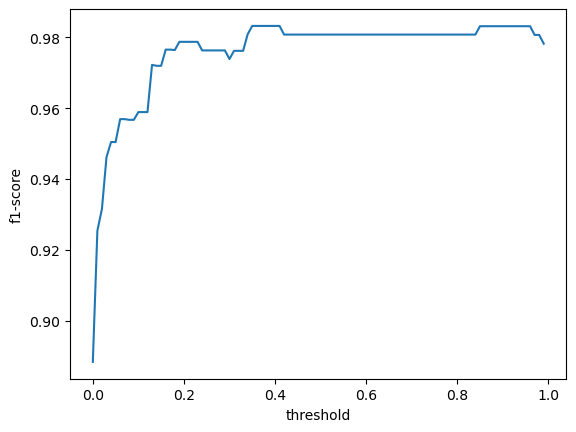

In [11]:
plt.plot(df_scores["threshold"], df_scores["f1-score"])
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.show()


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?


In [12]:
from sklearn.model_selection import KFold

scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    # split
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # one hot encoding
    X_train_dicts = df_train[features].to_dict(orient="records")
    X_val_dicts = df_val[features].to_dict(orient="records")
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(X_train_dicts)
    X_val = dv.transform(X_val_dicts)

    # target variable
    y_train = df_train["card"]
    y_val = df_val["card"]

    # train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # validation
    y_prob = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_prob)
    scores.append(auc)

print(f"auc = {np.mean(scores):.3f} +- {np.std(scores):.3f}")

auc = 0.996 +- 0.003



## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?


In [13]:
c_scores = []
for C in [0.01, 0.1, 1, 10]:
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        # split
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # one hot encoding
        X_train_dicts = df_train[features].to_dict(orient="records")
        X_val_dicts = df_val[features].to_dict(orient="records")
        
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(X_train_dicts)
        X_val = dv.transform(X_val_dicts)

        # target variable
        y_train = df_train["card"]
        y_val = df_val["card"]

        # train model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # validation
        y_prob = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_prob)
        scores.append(auc)

    auc_mean = np.mean(scores)
    auc_std = np.std(scores)

    c_scores.append({
        "C": C,
        "auc_mean": round(auc_mean, 3),
        "auc_std": round(auc_std, 3)
    })

pd.DataFrame(c_scores).sort_values(by="auc_mean", ascending=False)

,C,auc_mean,auc_std
2,1.00,0.996,0.003
3,10.00,0.996,0.003
1,0.10,0.995,0.004
0,0.01,0.992,0.006
